Step 1 ( MIS): Data Collection with Proxy Rewards
 
 **Scenario:** Maximum Independent Set (MIS) on Dense Graphs.
 **Fixes Applied:**
 1. **Proxy Reward:** Reward = (Bound Improvement * 50) + (Cut Efficacy * 5).
    - Even if the Bound doesn't move (degeneracy), valid cuts get points for Efficacy.
 2. **Dense Graphs:** `gnp_random_graph` (p=0.15) creates highly fractional solutions (lots of 0.5s), providing rich training data.
 3. **ForceCut:** Forces SCIP to accept the cuts.

MIS Data Collection (Proxy Rewards)
  Ep 10/50 | Samples: 10 | Positive Rew: 1
  Ep 20/50 | Samples: 20 | Positive Rew: 1
  Ep 30/50 | Samples: 30 | Positive Rew: 1
  Ep 40/50 | Samples: 40 | Positive Rew: 1
  Ep 50/50 | Samples: 50 | Positive Rew: 1

 Saved to 'mis_proxy_data.pkl'


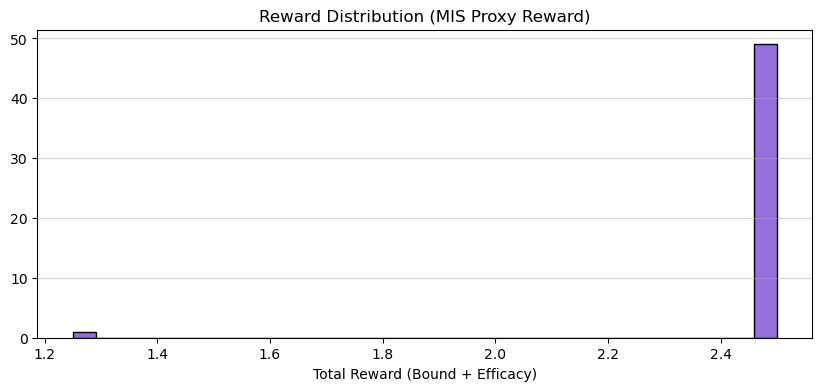

In [2]:
import networkx as nx
import numpy as np
import pickle
import random
from pyscipopt import Model, Sepa, Eventhdlr, SCIP_RESULT, SCIP_PARAMSETTING, SCIP_EVENTTYPE
import matplotlib.pyplot as plt

# 1. Feature Extractor
def get_features(model, row):
    cols = row.getCols()
    vals = row.getVals()
    rhs = row.getRhs()
    lhs = row.getLhs()
    cut_coeffs = np.array(vals)
    if len(cut_coeffs) == 0: return np.zeros(13, dtype=np.float32)

    obj_coeffs = []
    integral_var_count = 0
    for col in cols:
        try:
            var = col.getVar()
            c = var.getObj()
            vtype = var.vtype()
        except:
            c = col.getObj()
            vtype = col.vtype()
        obj_coeffs.append(c)
        if vtype in ["BINARY", "INTEGER", "IMPLINT"]:
            integral_var_count += 1
    obj_coeffs = np.array(obj_coeffs)
    
    # 1. Stats
    f_cut_mean = np.mean(cut_coeffs)
    f_cut_max  = np.max(cut_coeffs)
    f_cut_min  = np.min(cut_coeffs)
    f_cut_std  = np.std(cut_coeffs)
    
    # 2. Obj Stats
    if len(obj_coeffs) > 0:
        f_obj_mean = np.mean(obj_coeffs)
        f_obj_max  = np.max(obj_coeffs)
        f_obj_min  = np.min(obj_coeffs)
        f_obj_std  = np.std(obj_coeffs)
    else:
        f_obj_mean, f_obj_max, f_obj_min, f_obj_std = 0.0, 0.0, 0.0, 0.0
    
    # 3. Parallelism
    norm_cut = np.linalg.norm(cut_coeffs)
    norm_obj = np.linalg.norm(obj_coeffs)
    f_parallelism = 0.0
    if norm_cut > 1e-9 and norm_obj > 1e-9:
        f_parallelism = np.dot(cut_coeffs, obj_coeffs) / (norm_cut * norm_obj)
        
    # 4. Efficacy
    try:
        f_efficacy = model.getCutEfficacy(row)
    except:
        activity = model.getRowActivity(row)
        viol = 0.0
        if rhs < 1e20: viol = max(viol, activity - rhs)
        if lhs > -1e20: viol = max(viol, lhs - activity)
        f_efficacy = viol / norm_cut if norm_cut > 1e-9 else 0.0
    
    # 5. Structure
    n_vars_total = model.getNVars()
    f_support = len(cut_coeffs) / (n_vars_total + 1e-5)
    f_int_support = integral_var_count / (len(cut_coeffs) + 1e-5)
    
    # 6. Violation
    activity = model.getRowActivity(row)
    limit = rhs if rhs < 1e20 else lhs
    denom = abs(limit) if abs(limit) > 1e-9 else 1.0
    viol_val = 0.0
    if rhs < 1e20: viol_val = max(viol_val, activity - rhs)
    if lhs > -1e20: viol_val = max(viol_val, lhs - activity)
    f_norm_violation = viol_val / denom
    
    features = np.array([
        f_cut_mean, f_cut_max, f_cut_min, f_cut_std,
        f_obj_mean, f_obj_max, f_obj_min, f_obj_std,
        f_parallelism, f_efficacy, f_support, f_int_support, f_norm_violation
    ], dtype=np.float32)
    return features

# 2. Reward Monitor
class RewardMonitor(Eventhdlr):
    def __init__(self):
        self.data = []
        self.pending_transition = None 
        self.positive_rewards_count = 0

    def eventinit(self): 
        self.model.catchEvent(SCIP_EVENTTYPE.LPSOLVED, self)

    def eventexit(self): 
        self.model.dropEvent(SCIP_EVENTTYPE.LPSOLVED, self)

    def eventexec(self, event):
        # MIS is Maximize, Bound for Upper Bound (lower the better)
        current_db = self.model.getLPObjVal()
        
        if self.pending_transition:
            state, action_indices, old_db = self.pending_transition
            
            # A. Solver Reward (Bound Improvement)
            solver_reward = 0.0
            if old_db < 1e19 and current_db < 1e19:
                diff = old_db - current_db
                # filter
                if diff > 1e-5 and diff < 1000:
                    solver_reward = diff
            
            # B. Geometric Reward (Mean Efficacy)
            selected_efficacies = [state[idx][9] for idx in action_indices]
            geom_reward = 0.0
            if selected_efficacies:
                geom_reward = np.mean(selected_efficacies)
            
            # C. Total Proxy Reward
            total_reward = (solver_reward * 50.0) + (geom_reward * 5.0)
            
            # Store
            self.data.append({
                'state': state, 
                'action': action_indices, 
                'reward': total_reward
            })
            
            if total_reward > 0.001:
                self.positive_rewards_count += 1
            
            self.pending_transition = None
        return {}

# 3. Random Separator (ForceCut)
class RandomDataSepa(Sepa):
    def __init__(self, monitor):
        self.monitor = monitor

    def sepaexeclp(self):
        model = self.model
        vars = model.getVars()
        
        # 1. Find Devider Variables
        fractional_vars = []
        for v in vars:
            val = model.getSolVal(None, v)
            if 0.001 < val < 0.999:
                #close to 0.5
                dist = abs(val - 0.5)
                fractional_vars.append((dist, v))
        
        fractional_vars.sort(key=lambda x: x[0])
        top_vars = [v for d, v in fractional_vars[:15]]
        
        candidates = []
        if top_vars:
            for i, v in enumerate(top_vars):
                cut_name = f"mis_cut_{i}"
                val = model.getSolVal(None, v)
                
                # Create Bound Cut
                if val < 0.5:
                    row = model.createEmptyRowSepa(self, cut_name, lhs=None, rhs=0.0)
                    model.addVarToRow(row, v, 1.0)
                else:
                    row = model.createEmptyRowSepa(self, cut_name, lhs=1.0, rhs=None)
                    model.addVarToRow(row, v, 1.0)
                
                if model.isCutEfficacious(row):
                    candidates.append(row)
        
        if not candidates:
            return {"result": SCIP_RESULT.DIDNOTFIND}

        # 2. feature extraction
        state_features = [get_features(model, c) for c in candidates]
        
        # 3. random selection
        indices = list(range(len(candidates)))
        random.shuffle(indices)
        n_select = random.randint(1, len(candidates))
        selected_indices = indices[:n_select]
        
        for idx in selected_indices:
            try:
                model.addCut(candidates[idx], forcecut=True)
            except:
                model.addCut(candidates[idx]) # Fallback

        current_db = model.getLPObjVal()
        self.monitor.pending_transition = (state_features, selected_indices, current_db)
        
        return {"result": SCIP_RESULT.SEPARATED}

# 4. Main Execution (MIS Version)
def run_mis_proxy_collection():
    NUM_EPISODES = 50
    NODES = 60
    OUTPUT_FILE = "mis_proxy_data.pkl"
    
    all_dataset = []
    print(f"MIS Data Collection (Proxy Rewards)")

    for i in range(NUM_EPISODES):
        # Erdos-Renyi graph(p=0.15)
        # More fractional variables will be created than Barabasi-Albert graph.
        g = nx.gnp_random_graph(NODES, 0.15, seed=2505153)
        
        model = Model(f"MIS_Dense_{i}")
        model.hideOutput()
        
        # MIS Formulation: Max sum(x) s.t. x_u + x_v <= 1
        x = {n: model.addVar(vtype="B") for n in g.nodes()}
        for u, v in g.edges():
            model.addCons(x[u] + x[v] <= 1)
        model.setObjective(sum(x.values()), "maximize")
        
        model.setIntParam("separating/maxrounds", 5)
        model.setPresolve(SCIP_PARAMSETTING.OFF)
        
        monitor = RewardMonitor()
        model.includeEventhdlr(monitor, "RewardMonitor", "")
        sepa = RandomDataSepa(monitor)
        model.includeSepa(sepa, "RandomSepa", "", priority=100000, freq=1)
        
        model.optimize()
        
        if monitor.data:
            all_dataset.extend(monitor.data)
            
        if (i+1) % 10 == 0:
            print(f"  Ep {i+1}/{NUM_EPISODES} | Samples: {len(all_dataset)} | Positive Rew: {monitor.positive_rewards_count}")

    print(f"\n Saved to '{OUTPUT_FILE}'")
    with open(OUTPUT_FILE, "wb") as f:
        pickle.dump(all_dataset, f)
        
    # Plotting
    rewards = [d['reward'] for d in all_dataset]
    plt.figure(figsize=(10,4))
    plt.hist(rewards, bins=30, color='mediumpurple', edgecolor='black')
    plt.title("Reward Distribution (MIS Proxy Reward)")
    plt.xlabel("Total Reward (Bound + Efficacy)")
    plt.grid(axis='y', alpha=0.5)
    plt.show()


run_mis_proxy_collection()